# CNN Model Template

This notebook is a template for building a CNN model.

## Imports and inital setup

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2

# import classweights
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold

from time import sleep 
import cv2
import sys
import os

sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 856
NUM_EPOCHS = 20

# File path variables
# please make sure to use the correct path to the meta data file
FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  
FIELPATH_TESTOUTPUT= "./../data/testoutput/"
FILEPATH_MODELS= "../models/"
FILEPATH_LOGS= "../models/logs/"

TARGET_LABEL="dx_tertiary"

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 128

MONITOR = 'val_loss'

### Loading (augmented) metadata as test, train, validation from files

In [2]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

lesion_id                    image_id     dx    dx_type   age     sex   
2032  HAM_0002538            ISIC_0032240.jpg   vasc      histo  65.0  female  \
4128  HAM_0004036  aug_Ev7SktISIC_0027107.jpg     df      histo  55.0    male   
895   HAM_0005801            ISIC_0029576.jpg    bkl      histo  70.0  female   
729   HAM_0006148            ISIC_0033987.jpg    bkl  consensus  80.0  female   
1201  HAM_0001024            ISIC_0030683.jpg    bkl      histo  45.0    male   
3303  HAM_0002733            ISIC_0031041.jpg    bcc      histo  70.0    male   
3804  HAM_0007474  aug_2Ns15KISIC_0024848.jpg    bcc      histo  80.0    male   
2125  HAM_0005155  aug_mMh6UmISIC_0032076.jpg   vasc      histo  85.0    male   
1926  HAM_0004129            ISIC_0033977.jpg    mel      histo  70.0  female   
2256  HAM_0001852  aug_IOMSzTISIC_0034196.jpg   vasc      histo  80.0    male   
4377  HAM_0004756  aug_I49txpISIC_0029248.jpg     df      histo  55.0    male   
4434  HAM_0004317  aug_P8b1uqISIC_0025504.jpg     df      histo  50.0  female   
4341  HAM_0001785  aug_XBs8gHISIC_0034169.jpg     df      histo  50.0    male   
3088  HAM_0006002  aug_yVOwspISIC_0029915.jpg  akiec      histo  50.0  female   
3062  HAM_0005459  aug_cwTkblISIC_0032397.jpg  akiec      histo  85.0    male   

         localization       dataset        dx_binary     dx_tertiary   
2032          abdomen  vidir_modern  not_skin_cancer  non-neoplastic  \
4128  upper extremity     rosendahl  not_skin_cancer  non-neoplastic   
895           abdomen  vidir_modern  not_skin_cancer  non-neoplastic   
729              back  vidir_modern  not_skin_cancer  non-neoplastic   
1201             face     rosendahl  not_skin_cancer  non-neoplastic   
3303            chest     rosendahl      skin_cancer       malignant   
3804             back     rosendahl      skin_cancer       malignant   
2125  lower extremity  vidir_modern  not_skin_cancer  non-neoplastic   
1926  upper extremity  vidir_modern      skin_cancer       malignant   
2256  lower extremity  vidir_modern  not_skin_cancer  non-neoplastic   
4377  lower extremity   vienna_dias  not_skin_cancer  non-neoplastic   
4434  lower extremity     rosendahl  not_skin_cancer  non-neoplastic   
4341  upper extremity  vidir_modern  not_skin_cancer  non-neoplastic   
3088             face  vidir_modern      skin_cancer       malignant   
3062  upper extremity     rosendahl      skin_cancer       malignant   

                                     image_path  
2032            ./../data/jpgs/ISIC_0032240.jpg  
4128  ./../data/jpgs/aug_Ev7SktISIC_0027107.jpg  
895             ./../data/jpgs/ISIC_0029576.jpg  
729             ./../data/jpgs/ISIC_0033987.jpg  
1201            ./../data/jpgs/ISIC_0030683.jpg  
3303            ./../data/jpgs/ISIC_0031041.jpg  
3804  ./../data/jpgs/aug_2Ns15KISIC_0024848.jpg  
2125  ./../data/jpgs/aug_mMh6UmISIC_0032076.jpg  
1926            ./../data/jpgs/ISIC_0033977.jpg  
2256  ./../data/jpgs/aug_IOMSzTISIC_0034196.jpg  
4377  ./../data/jpgs/aug_I49txpISIC_0029248.jpg  
4434  ./../data/jpgs/aug_P8b1uqISIC_0025504.jpg  
4341  ./../data/jpgs/aug_XBs8gHISIC_0034169.jpg  
3088  ./../data/jpgs/aug_yVOwspISIC_0029915.jpg  
3062  ./../data/jpgs/aug_cwTkblISIC_0032397.jpg

## Setting up the image data generator for training and validation

In [3]:
def custom_preprocessing(np_image, image_size, show_image=False):
    # print the image
    # print("From custom_preprocessing: Image + shape before preprocessing:", np_image.shape)
    np_image = np_image.astype(np.uint8)
    
    #print(np_image)
    if show_image:
        plt.imshow(np_image.astype(np.uint8))
        plt.show()

    # rescale 
    np_image = np_image / 255.0

    # Using the image helper functions
    np_image = ih.center_crop_image(np_image) # Crop image to square format
    
    if show_image:
        print("From custom_preprocessing: Image after center crop:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    np_image = ih.resize_as_preprocess(np_image, image_size) # resize the image

    if show_image:
        print("From custom_preprocessing: Image after after resizing:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    return np_image

In [4]:
# #print("sample augmented image from HDD:")
# sample_img_path = "./../data/jpgs/aug_s8yXnVISIC_0030555.jpg"
# sample_img = plt.imread(sample_img_path)

# # normalize the pixel values as it would happen in the model
# #sample_img = sample_img / 255.0

# processed_img = custom_preprocessing(sample_img, IMAGE_SIZE, show_image=False) 

# #print("sample orig image from HDD:")
# sample_img_path = "./../data/jpgs/ISIC_0030571.jpg"
# sample_img = plt.imread(sample_img_path)

# # normalize the pixel values as it would happen in the model

# processed_img = custom_preprocessing(sample_img, IMAGE_SIZE, show_image=False)

In [5]:
# Setting up the Image Data Generator for the train data set

datagen_train = ImageDataGenerator(
    rotation_range=180, # Degree range for random rotations
    horizontal_flip=True, # Randomly flip inputs horizontally
    vertical_flip=True, # Randomly flip inputs vetically
    zoom_range=0.2, # Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE), # Apply the custom preprocessing function 
)

datagen_validation = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE)
)

train_data_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    color_mode='rgb',
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,

    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 4554 validated image filenames belonging to 3 classes.
Found 1001 validated image filenames belonging to 3 classes.


In [6]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen)  
    plt.figure(figsize=(25, 25))
    length = len(labels)
    if length < 25:  
        r = length
    else:
        r = 25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i]  
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

In [7]:
images, labels = next(train_data_generator)
print(images.min(), images.max(), images.dtype)

0.0 1.0 float32


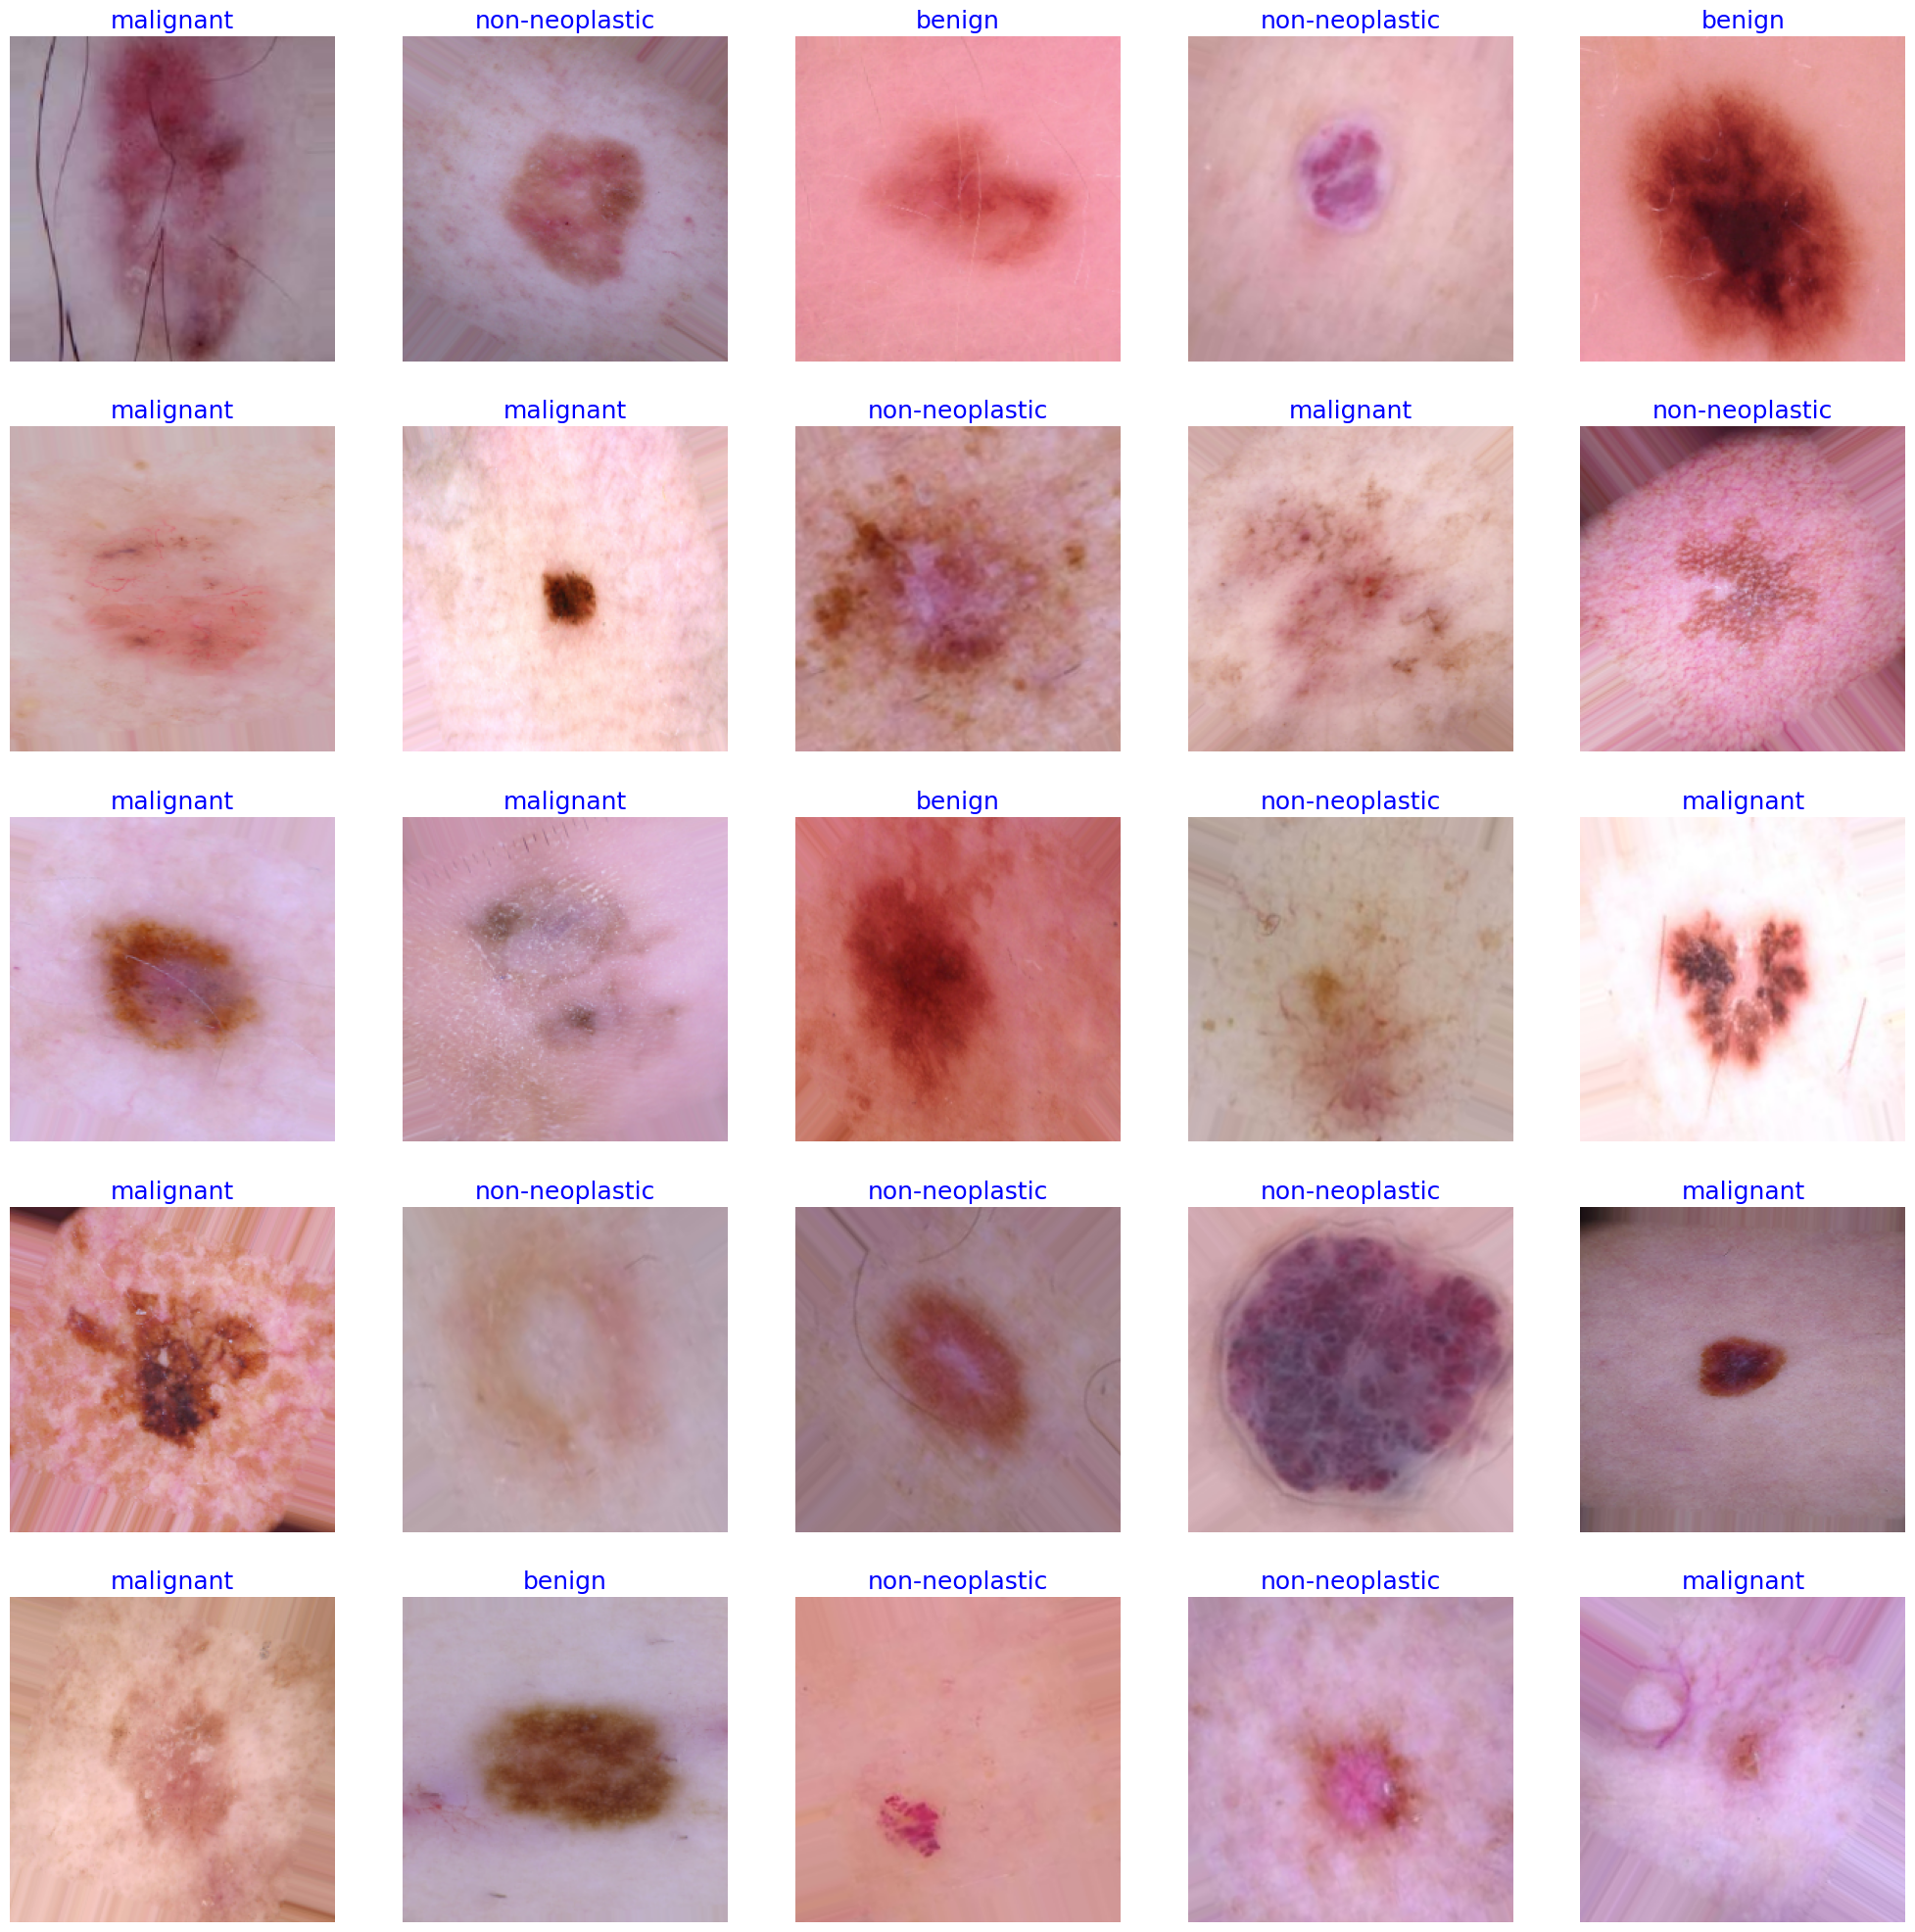

In [8]:
show_image_samples(train_data_generator)

# Using MobileNet V3 small

## Model setup

### Class weights

In [9]:
# calculating class weights

classes = np.unique(train_data_generator.classes)
y_train = train_data_generator.classes

print("classes:", classes)
print("y_train:", y_train)

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = classes, 
    y = y_train)

print("class weights:", class_weights)

# Convert the computed class weights to a dictionary for use in TensorFlow
class_weight_dict = {i: class_weights[i] for i in range(len(classes))}

print("class_weight_dict:", class_weight_dict)

classes: [0 1 2]
y_train: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### Metric: f1 score

In [10]:
def f1_score(y_true, y_pred):
    # Calculate precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculate recall
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    # Calculate F1 score
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Loss function: focal loss

In [11]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

In [12]:
def focal_loss2(alpha, gamma=2.0):
    alpha = tf.convert_to_tensor(alpha, dtype=tf.float32)
    def multi_class_focal_loss(y_true, y_pred):
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, dtype=y_pred.dtype)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return multi_class_focal_loss

alpha_set = list(class_weight_dict.values())


### Callback: EarlyStopping

In [13]:
stop_early = EarlyStopping(
    monitor='val_f1_score',
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=4,
    )

### Callback: ModelCheckpoint

In [14]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=FILEPATH_MODELS,
    save_weights_only=True,
    monitor=MONITOR,
    mode='max',
    save_best_only=True)

### Callback: TensorBoard

In [15]:
tensorboard = TensorBoard(
    log_dir=FILEPATH_LOGS,
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq="epoch",
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None,
)

### Callback: Image Comparison

In [16]:
class ImageComparisonCallback(Callback):
    def __init__(self, generator, base_dir):
        super(ImageComparisonCallback, self).__init__()
        self.generator = generator
        self.base_dir = base_dir

    def on_epoch_begin(self, epoch, logs=None):
        # Reset the generator
        self.generator.reset()

        # Get the first batch of images from the generator
        img_gen_batch, _ = next(self.generator)
        
        # Get the index of the first image in this batch relative to self.generator.filenames
        idx = self.generator.index_array[0]
        
        # Pick the image from the batch using this index and its corresponding filename
        img_gen_array = img_gen_batch[0]
        filename = self.generator.filenames[idx]

        # Load the corresponding image from disk
        img_path = os.path.join(self.base_dir, filename)
        img_disk = image.load_img(img_path, target_size=self.generator.image_shape[:2])
        img_disk_array = image.img_to_array(img_disk)

        # Compare the two arrays
        is_same = np.array_equal(img_disk_array, img_gen_array)
        if is_same:
            print("The images are identical!")
        else:
            print("The images are different!")
            np.array_diff = img_disk_array - img_gen_array*255

        # Display both images for comparison
        fig, axes = plt.subplots(1, 2, figsize=(8, 3))
        axes[0].imshow(img_disk_array.astype('uint8'))
        axes[0].set_title(f'Image from Disk: {filename}')
        axes[0].axis('off')

        # If the generator normalizes images to [0,1], we multiply by 255 for proper visualization
        axes[1].imshow((img_gen_array*255).astype('uint8'))
        axes[1].set_title('Image from Generator')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

# Usage: Assuming you have already defined a generator, `train_generator`, and a base directory, `data_dir`
# callback = ImageComparisonCallback(train_generator, data_dir)

base_dir = FILEPATH_JPGS

### Callback: RandomImagefromValGen

In [17]:
class DisplayRandomImageCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator):
        super().__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        # Get a random batch of images and labels
        x_val, y_val = next(self.val_generator)

        # Choose a random image and label from the batch
        idx = np.random.choice(x_val.shape[0])
        image, label = x_val[idx], y_val[idx]

        # Display the image with its label
        plt.figure(figsize=(5,5))
        plt.imshow((image*255).astype('uint8'))
        plt.title(f"Label: {np.argmax(label)}")
        plt.axis('off')
        plt.show()

val_callback = DisplayRandomImageCallback(validation_generator)

### Optimizer: SDG

In [18]:
opt_SDG = SGD(learning_rate=0.001, 
            momentum=0.9
            # nesterov=True,
            # decay=0.01
            )

### Optimizer: Adam

In [19]:
opt_ADAM = Adam(learning_rate=0.0001)

### Callback: ReaduceLROnPlateau

In [20]:
reduce_lr = ReduceLROnPlateau(monitor=MONITOR, factor=0.2, patience=3, verbose=1, min_lr=0.000001)

### Model: Name

In [21]:
NAME = "tertiary_mobileNet-SMALL_trainable-weights_weights-balanced"

### CONFIG: Regularization strength

In [22]:
reg_strength = 0.005

### Model: Architecture

In [23]:
PRETRAINED = True

if PRETRAINED:
    # Initialize the MobileNetV3Large model
    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # Freeze the base model's layers to use it for feature extraction
    for layer in base_model.layers:
        layer.trainable = True

    # Add custom layers on top 
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(reg_strength))(base_model.output)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(reg_strength))(x)

    # Global max pooling instead of flattening
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    
    # x = layers.Dense(128, activation='relu', kernel_regularizer=l2(reg_strength))(x)

    x = layers.Dropout(0.5)(x)  #dropout

    x = layers.Dense(train_df[TARGET_LABEL].nunique(), activation='softmax', kernel_regularizer=l2(reg_strength))(x) 

    # Create the full model
    model = Model(inputs=base_model.input, outputs=x, name=NAME)
    
    model.compile(optimizer=opt_SDG,
                loss=focal_loss2(alpha=alpha_set, gamma=2.0),
                metrics=[
                        'accuracy',
                        f1_score
                        ])  

    model.summary()

else:
    # Initialize the MobileNetV3Large model
    base_model = MobileNetV3Small(weights=None, include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # Freeze the base model's layers to use it for feature extraction
    for layer in base_model.layers:
        layer.trainable = True

    # Add custom layers on top 
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(base_model.output)

    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)

    # Global average pooling instead of flattening
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # x = layers.Dense(128, activation='relu')(x)

    x = layers.Dropout(0.7)(x)  #dropout

    x = layers.Dense(train_df[TARGET_LABEL].nunique(), activation='softmax')(x) 

    # Create the full model
    model = Model(inputs=base_model.input, outputs=x, name=NAME)
    
    model.compile(optimizer=opt_ADAM,
                loss='categorical_crossentropy',
                metrics=[
                        'accuracy',
                        f1_score
                        ])

    model.summary()


Model: "tertiary_mobileNet-SMALL_trainable-weights_weights-balanced"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                              

## Model Training

The images are different!


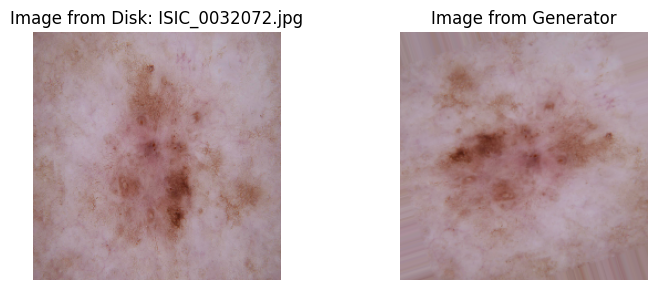

Epoch 1/20
36/36 [==============================] - ETA: 0s - loss: 1.6944 - accuracy: 0.3948 - f1_score: 0.3118

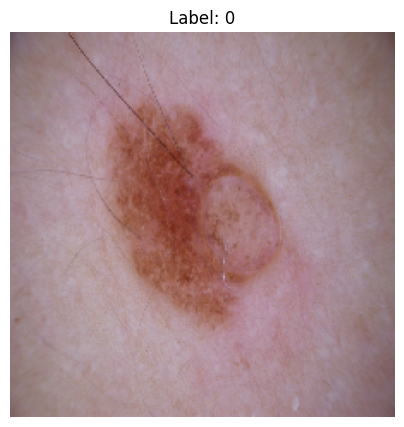

36/36 [==============================] - 125s 3s/step - loss: 1.6944 - accuracy: 0.3948 - f1_score: 0.3118 - val_loss: 1.4331 - val_accuracy: 0.1359 - val_f1_score: 0.0000e+00 - lr: 0.0010
The images are different!


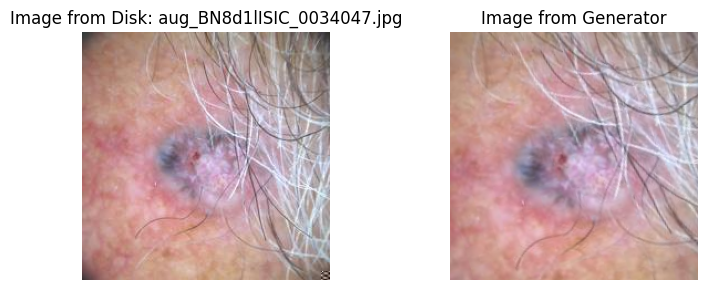

Epoch 2/20
36/36 [==============================] - ETA: 0s - loss: 1.0280 - accuracy: 0.3867 - f1_score: 0.1516

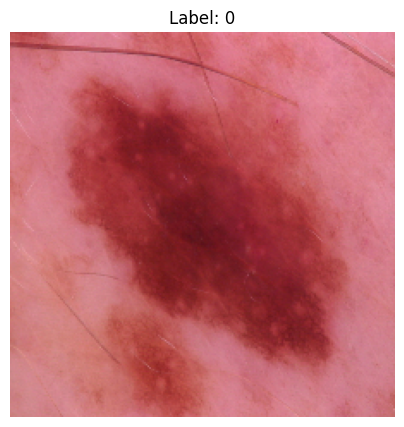

36/36 [==============================] - 111s 3s/step - loss: 1.0280 - accuracy: 0.3867 - f1_score: 0.1516 - val_loss: 1.3841 - val_accuracy: 0.1359 - val_f1_score: 0.0000e+00 - lr: 0.0010
The images are different!


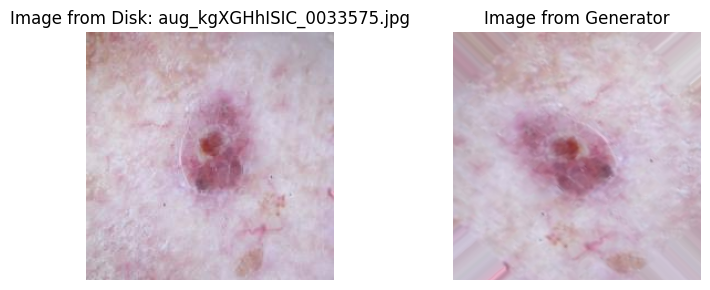

Epoch 3/20
36/36 [==============================] - ETA: 0s - loss: 0.9668 - accuracy: 0.4605 - f1_score: 0.2187

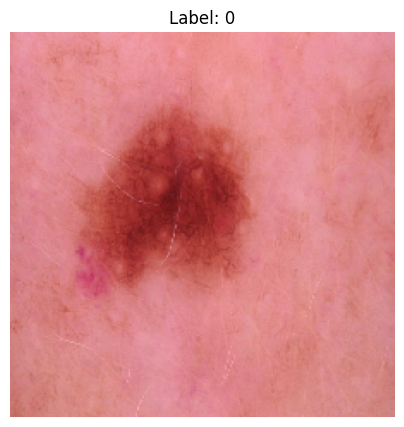

36/36 [==============================] - 113s 3s/step - loss: 0.9668 - accuracy: 0.4605 - f1_score: 0.2187 - val_loss: 1.3710 - val_accuracy: 0.1359 - val_f1_score: 0.0000e+00 - lr: 0.0010
The images are different!


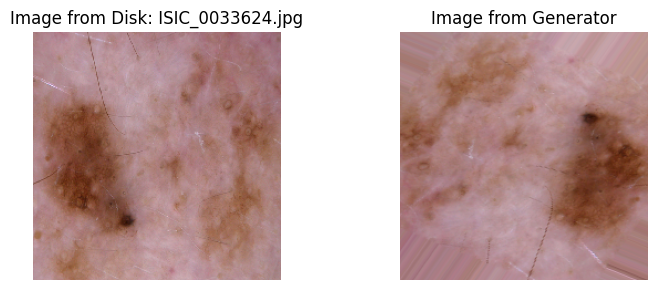

Epoch 4/20
36/36 [==============================] - ETA: 0s - loss: 0.9279 - accuracy: 0.5147 - f1_score: 0.3127

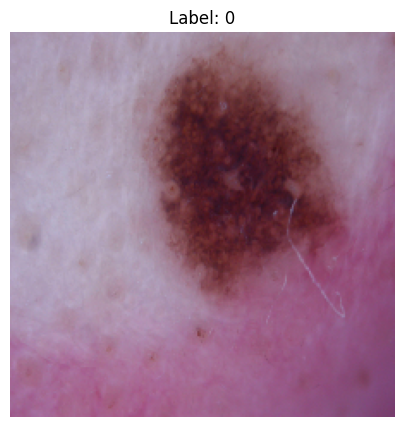

36/36 [==============================] - 114s 3s/step - loss: 0.9279 - accuracy: 0.5147 - f1_score: 0.3127 - val_loss: 1.3424 - val_accuracy: 0.1359 - val_f1_score: 0.0000e+00 - lr: 0.0010
The images are different!


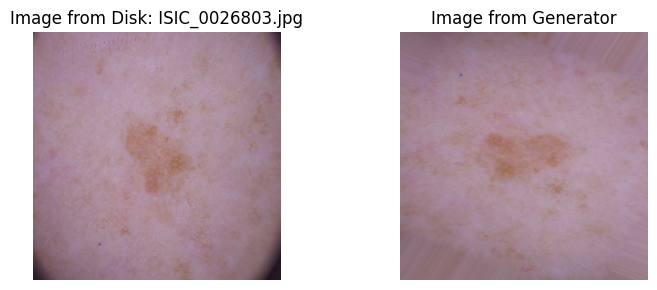

Epoch 5/20
36/36 [==============================] - ETA: 0s - loss: 0.8956 - accuracy: 0.5299 - f1_score: 0.3846

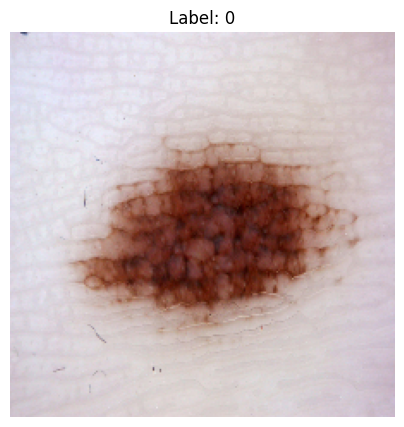

36/36 [==============================] - 113s 3s/step - loss: 0.8956 - accuracy: 0.5299 - f1_score: 0.3846 - val_loss: 1.3863 - val_accuracy: 0.1359 - val_f1_score: 0.0000e+00 - lr: 0.0010
The images are different!


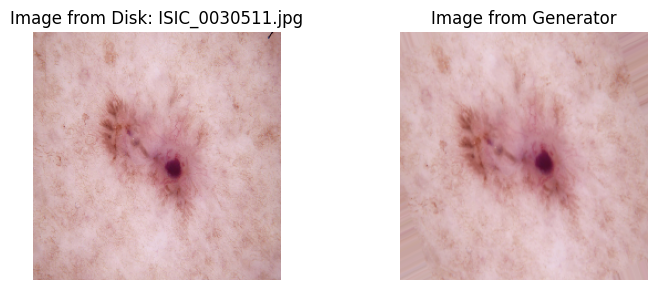

Epoch 6/20
36/36 [==============================] - ETA: 0s - loss: 0.8648 - accuracy: 0.5663 - f1_score: 0.4393

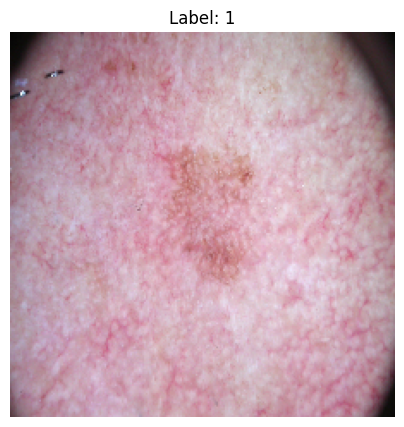

36/36 [==============================] - 115s 3s/step - loss: 0.8648 - accuracy: 0.5663 - f1_score: 0.4393 - val_loss: 1.3793 - val_accuracy: 0.1359 - val_f1_score: 0.0000e+00 - lr: 0.0010
The images are different!


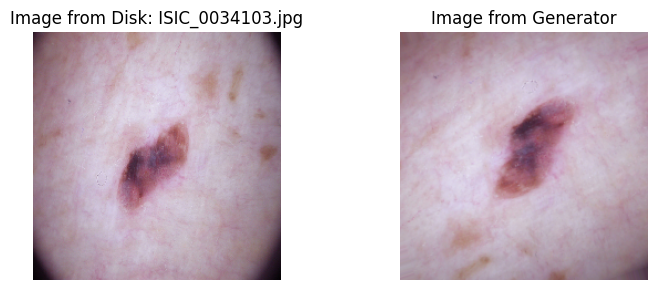

Epoch 7/20
36/36 [==============================] - ETA: 0s - loss: 0.8355 - accuracy: 0.5913 - f1_score: 0.4774
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


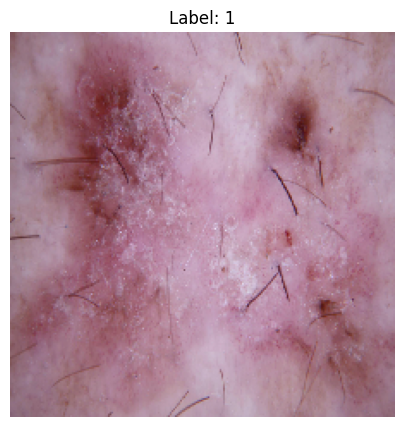

36/36 [==============================] - 119s 3s/step - loss: 0.8355 - accuracy: 0.5913 - f1_score: 0.4774 - val_loss: 1.3595 - val_accuracy: 0.1359 - val_f1_score: 0.0000e+00 - lr: 0.0010


In [24]:
# Train the model

history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,              
    verbose=1,                      # Adjust verbosity level
    batch_size=BATCH_SIZE,          # Set the batch size, default is 32, can be increased to speed up training
    callbacks=[
        reduce_lr,
        stop_early,
        tensorboard,
        model_checkpoint_callback,
        ImageComparisonCallback(train_data_generator, base_dir),
        val_callback
        ],                 
    validation_data=validation_generator,
    shuffle=True,                   # Shuffle the training data before each epoch
    sample_weight=None,             # Set the weights for the train data set
    class_weight=class_weight_dict,     # Set the weights for the classes, not needed if we use sample weights
    initial_epoch=0,                # Use this to continue training from a specific epoch
    steps_per_epoch=None,           # Set the number of steps per epoch, default is len(x_train) // batch_size
    validation_freq=1,              # Only relevant if validation data is a generator. Set the frequency to validate the model on the validation set
    max_queue_size=10,              # Set the max size for the generator queue
    workers=-1,                     # Set the max number of processes to generate the data in parallel, -1 means all CPUs
    use_multiprocessing=False       # Set to True if you use a generator in parallel, e.g. model.predict_generator()
)

## Plotting accuracy and loss of train and validation set

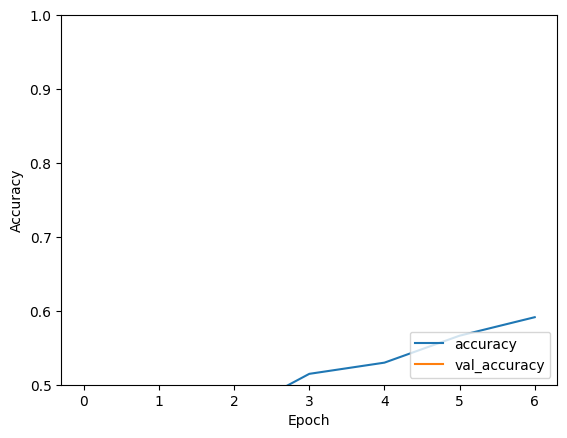

In [25]:
mh.model_plot_accuracy(history)

## Evaluating the model on the test set

 > Evaluating model tertiary_mobileNet-SMALL_trainable-weights_weights-balanced:
 > Loading test images...
 > Test images loaded.


 > Converting labels to one hot format...
 > Getting model predictions...
32/32 [==============================] - 3s 85ms/step
 > Model predictions obtained.
 > Macro AUC: 0.45993545251094936
 > Micro AUC: 0.4611047366345154


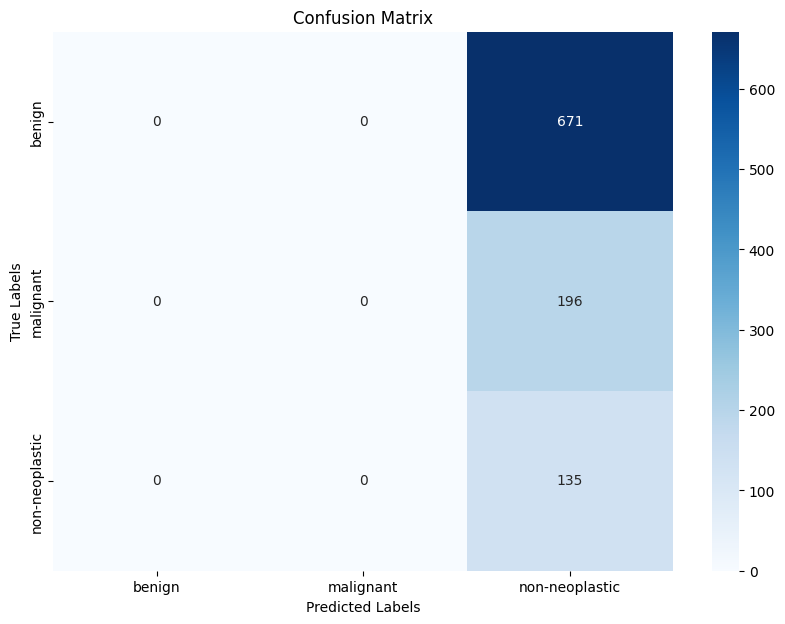



 > Computing classification report...
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       671
           1       0.00      0.00      0.00       196
           2       0.13      1.00      0.24       135

    accuracy                           0.13      1002
   macro avg       0.04      0.33      0.08      1002
weighted avg       0.02      0.13      0.03      1002

 > Evaluating model on test set...


/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

32/32 [==============================] - 3s 98ms/step - loss: 1.3581 - accuracy: 0.1347 - f1_score: 0.0000e+00
loss: 1.3581018447875977
accuracy: 0.1347305327653885
f1_score: 0.0
 > Done.


([{'loss': 1.3581018447875977},
  {'accuracy': 0.1347305327653885},
  {'f1_score': 0.0}],
 array([[  0,   0, 671],
        [  0,   0, 196],
        [  0,   0, 135]]),
 (0.4611047366345154, 0.45993545251094936))

In [26]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

## Saving the model

In [27]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"{FILEPATH_MODELS}model_{timestamp}.h5"
model.save(model_path)

/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
